<a href="https://colab.research.google.com/github/vicotrbb/machine_learning/blob/master/computational_vision/poc_augmented_reality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opencv-python

In [47]:
from google.colab import drive
drive.mount('/gdrive')

%cd /gdrive/MyDrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/MyDrive


In [49]:
%cd poc_ar
%ls

/gdrive/MyDrive/poc_ar
pirate-ship-fat.obj  reference.jpeg  video_hd.mp4
reference_board.png  test.JPG


In [4]:
class OBJ:
    def __init__(self, filename, swapyz=False):
        """Loads a Wavefront OBJ file. """
        self.vertices = []
        self.normals = []
        self.texcoords = []
        self.faces = []
        material = None
        for line in open(filename, "r"):
            if line.startswith('#'): continue
            values = line.split()
            if not values: continue
            if values[0] == 'v':
                v = list(map(float, values[1:4]))
                if swapyz:
                    v = v[0], v[2], v[1]
                self.vertices.append(v)
            elif values[0] == 'vn':
                v = list(map(float, values[1:4]))
                if swapyz:
                    v = v[0], v[2], v[1]
                self.normals.append(v)
            elif values[0] == 'vt':
                self.texcoords.append(map(float, values[1:3]))
            elif values[0] == 'f':
                face = []
                texcoords = []
                norms = []
                for v in values[1:]:
                    w = v.split('/')
                    face.append(int(w[0]))
                    if len(w) >= 2 and len(w[1]) > 0:
                        texcoords.append(int(w[1]))
                    else:
                        texcoords.append(0)
                    if len(w) >= 3 and len(w[2]) > 0:
                        norms.append(int(w[2]))
                    else:
                        norms.append(0)
                #self.faces.append((face, norms, texcoords, material))
                self.faces.append((face, norms, texcoords))

In [11]:
import cv2
import numpy as np
import math
import os
from google.colab.patches import cv2_imshow

MIN_MATCHES = 10

def main():
    """
    This functions loads the target surface image,
    """
    count = 0
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    homography = None 
    camera_parameters = np.array([[640, 0, 352], [0, 640, 352], [0, 0, 1]])
    orb = cv2.ORB_create()
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    dir_name = os.getcwd()
    model = cv2.imread('reference_board.png', 0)
    kp_model, des_model = orb.detectAndCompute(model, None)
    obj = OBJ('pirate-ship-fat.obj', swapyz=False)  
    cap = cv2.VideoCapture('video.mp4')
    out = cv2.VideoWriter('out.avi', fourcc, 20.0, (int(cap.get(3)),int(cap.get(4))))

    while cap.isOpened():
        # read the current frame
        ret, frame = cap.read()
        if not ret:
            print("Unable to capture video, stream ending")
            break
        # find and draw the keypoints of the frame
        kp_frame, des_frame = orb.detectAndCompute(frame, None)
        # match frame descriptors with model descriptors
        matches = bf.match(des_model, des_frame)
        # sort them in the order of their distance
        # the lower the distance, the better the match
        matches = sorted(matches, key=lambda x: x.distance)

        # compute Homography if enough matches are found
        if len(matches) > MIN_MATCHES:
            # differenciate between source points and destination points
            src_pts = np.float32([kp_model[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
            dst_pts = np.float32([kp_frame[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
            # compute Homography
            homography, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
            if True:
                # Draw a rectangle that marks the found model in the frame
                h, w = model.shape
                pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
                # project corners into frame
                dst = cv2.perspectiveTransform(pts, homography)
                # connect them with lines  
                frame = cv2.polylines(frame, [np.int32(dst)], True, 255, 3, cv2.LINE_AA)
            # if a valid homography matrix was found render cube on model plane
            if homography is not None:
                try:
                    projection = projection_matrix(camera_parameters, homography)  
                    frame = render(frame, obj, projection, model, False)
                    out.write(frame)
                    count += 1
                except:
                    pass

        else:
            print ("Not enough matches found - %d/%d" % (len(matches), MIN_MATCHES))

    cap.release()
    out.release()
    return count

def render(img, obj, projection, model, color=False):
    """
    Render a loaded obj model into the current video frame
    """
    vertices = obj.vertices
    scale_matrix = np.eye(3) * 3
    h, w = model.shape

    for face in obj.faces:
        face_vertices = face[0]
        points = np.array([vertices[vertex - 1] for vertex in face_vertices])
        points = np.dot(points, scale_matrix)
        # render model in the middle of the reference surface. To do so,
        # model points must be displaced
        points = np.array([[p[0] + w / 2, p[1] + h / 2, p[2]] for p in points])
        dst = cv2.perspectiveTransform(points.reshape(-1, 1, 3), projection)
        imgpts = np.int32(dst)
        if color is False:
            cv2.fillConvexPoly(img, imgpts, (137, 27, 211))
        else:
            color = hex_to_rgb(face[-1])
            color = color[::-1]  # reverse
            cv2.fillConvexPoly(img, imgpts, color)

    return img

def projection_matrix(camera_parameters, homography):
    """
    From the camera calibration matrix and the estimated homography
    compute the 3D projection matrix
    """
    # Compute rotation along the x and y axis as well as the translation
    homography = homography * (-1)
    rot_and_transl = np.dot(np.linalg.inv(camera_parameters), homography)
    col_1 = rot_and_transl[:, 0]
    col_2 = rot_and_transl[:, 1]
    col_3 = rot_and_transl[:, 2]
    # normalise vectors
    l = math.sqrt(np.linalg.norm(col_1, 2) * np.linalg.norm(col_2, 2))
    rot_1 = col_1 / l
    rot_2 = col_2 / l
    translation = col_3 / l
    # compute the orthonormal basis
    c = rot_1 + rot_2
    p = np.cross(rot_1, rot_2)
    d = np.cross(c, p)
    rot_1 = np.dot(c / np.linalg.norm(c, 2) + d / np.linalg.norm(d, 2), 1 / math.sqrt(2))
    rot_2 = np.dot(c / np.linalg.norm(c, 2) - d / np.linalg.norm(d, 2), 1 / math.sqrt(2))
    rot_3 = np.cross(rot_1, rot_2)
    # finally, compute the 3D projection matrix from the model to the current frame
    projection = np.stack((rot_1, rot_2, rot_3, translation)).T
    return np.dot(camera_parameters, projection)

def hex_to_rgb(hex_color):
    """
    Helper function to convert hex strings to RGB
    """
    hex_color = hex_color.lstrip('#')
    h_len = len(hex_color)
    return tuple(int(hex_color[i:i + h_len // 3], 16) for i in range(0, h_len, h_len // 3))

In [12]:
main()

Unable to capture video, stream ending


571

## Feature extraction

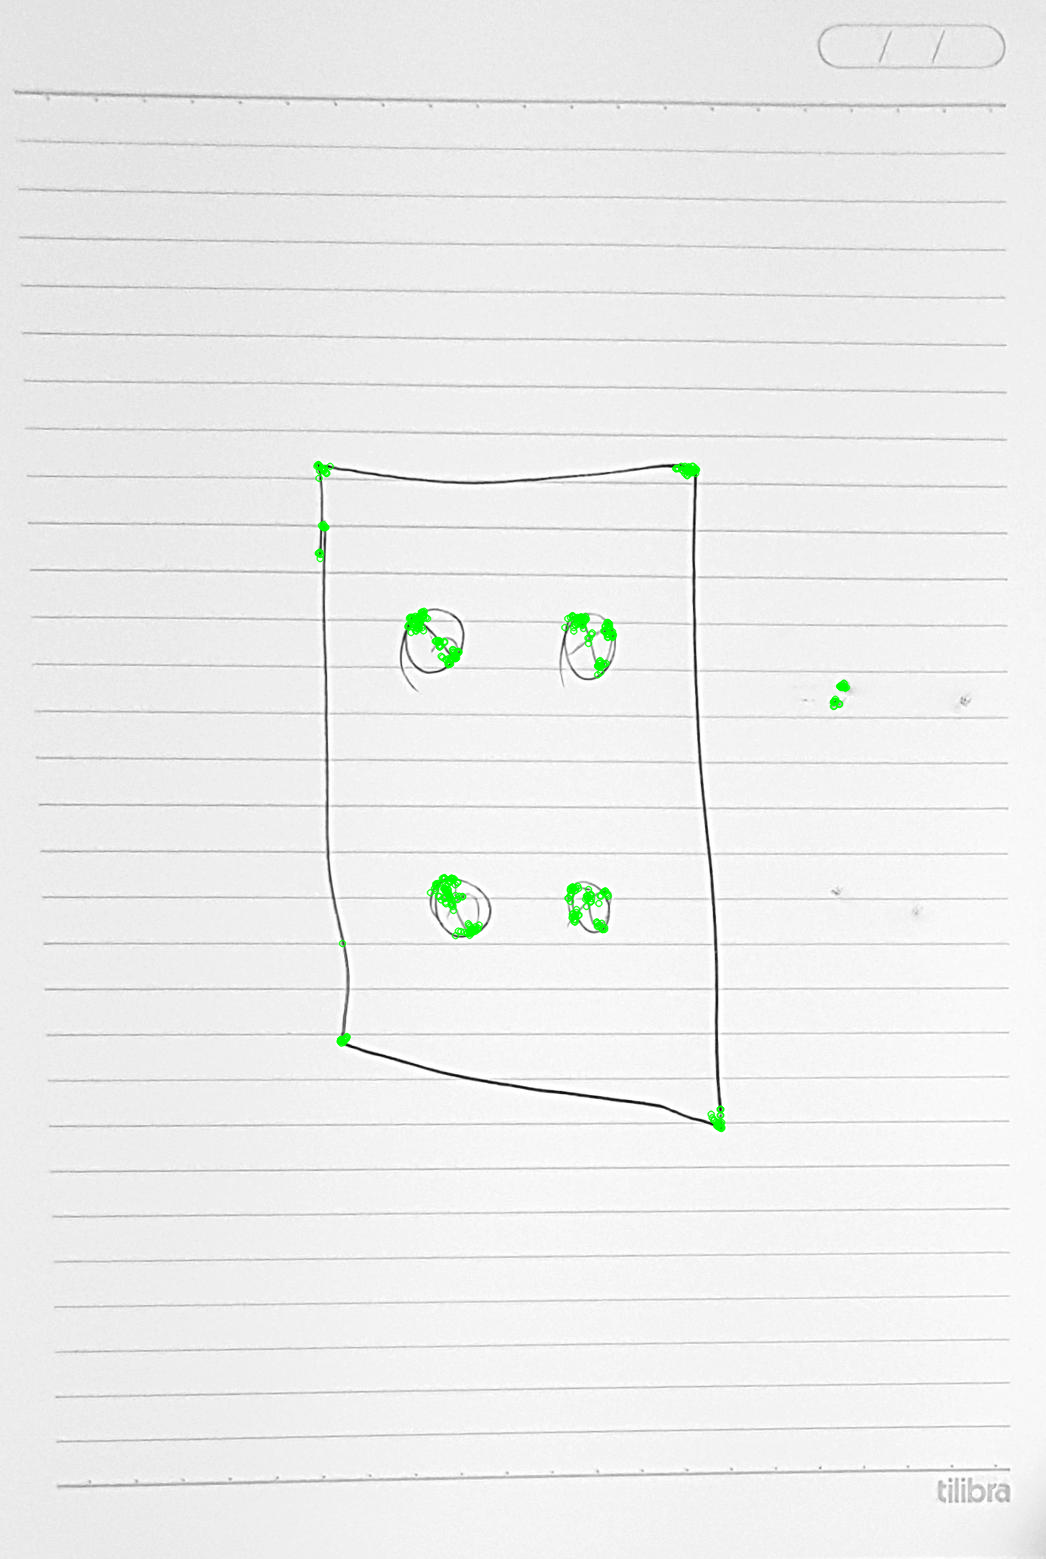

In [39]:
img = cv2.imread('reference.jpeg',0)
ref = cv2.imread('reference_board.png',0)
orb = cv2.ORB_create()
kp = orb.detect(img, None)
kp, des = orb.compute(img, kp)
img2 = cv2.drawKeypoints(img, kp, img, color=(0,255,0), flags=0)

cv2_imshow(img2)

## Feature matching

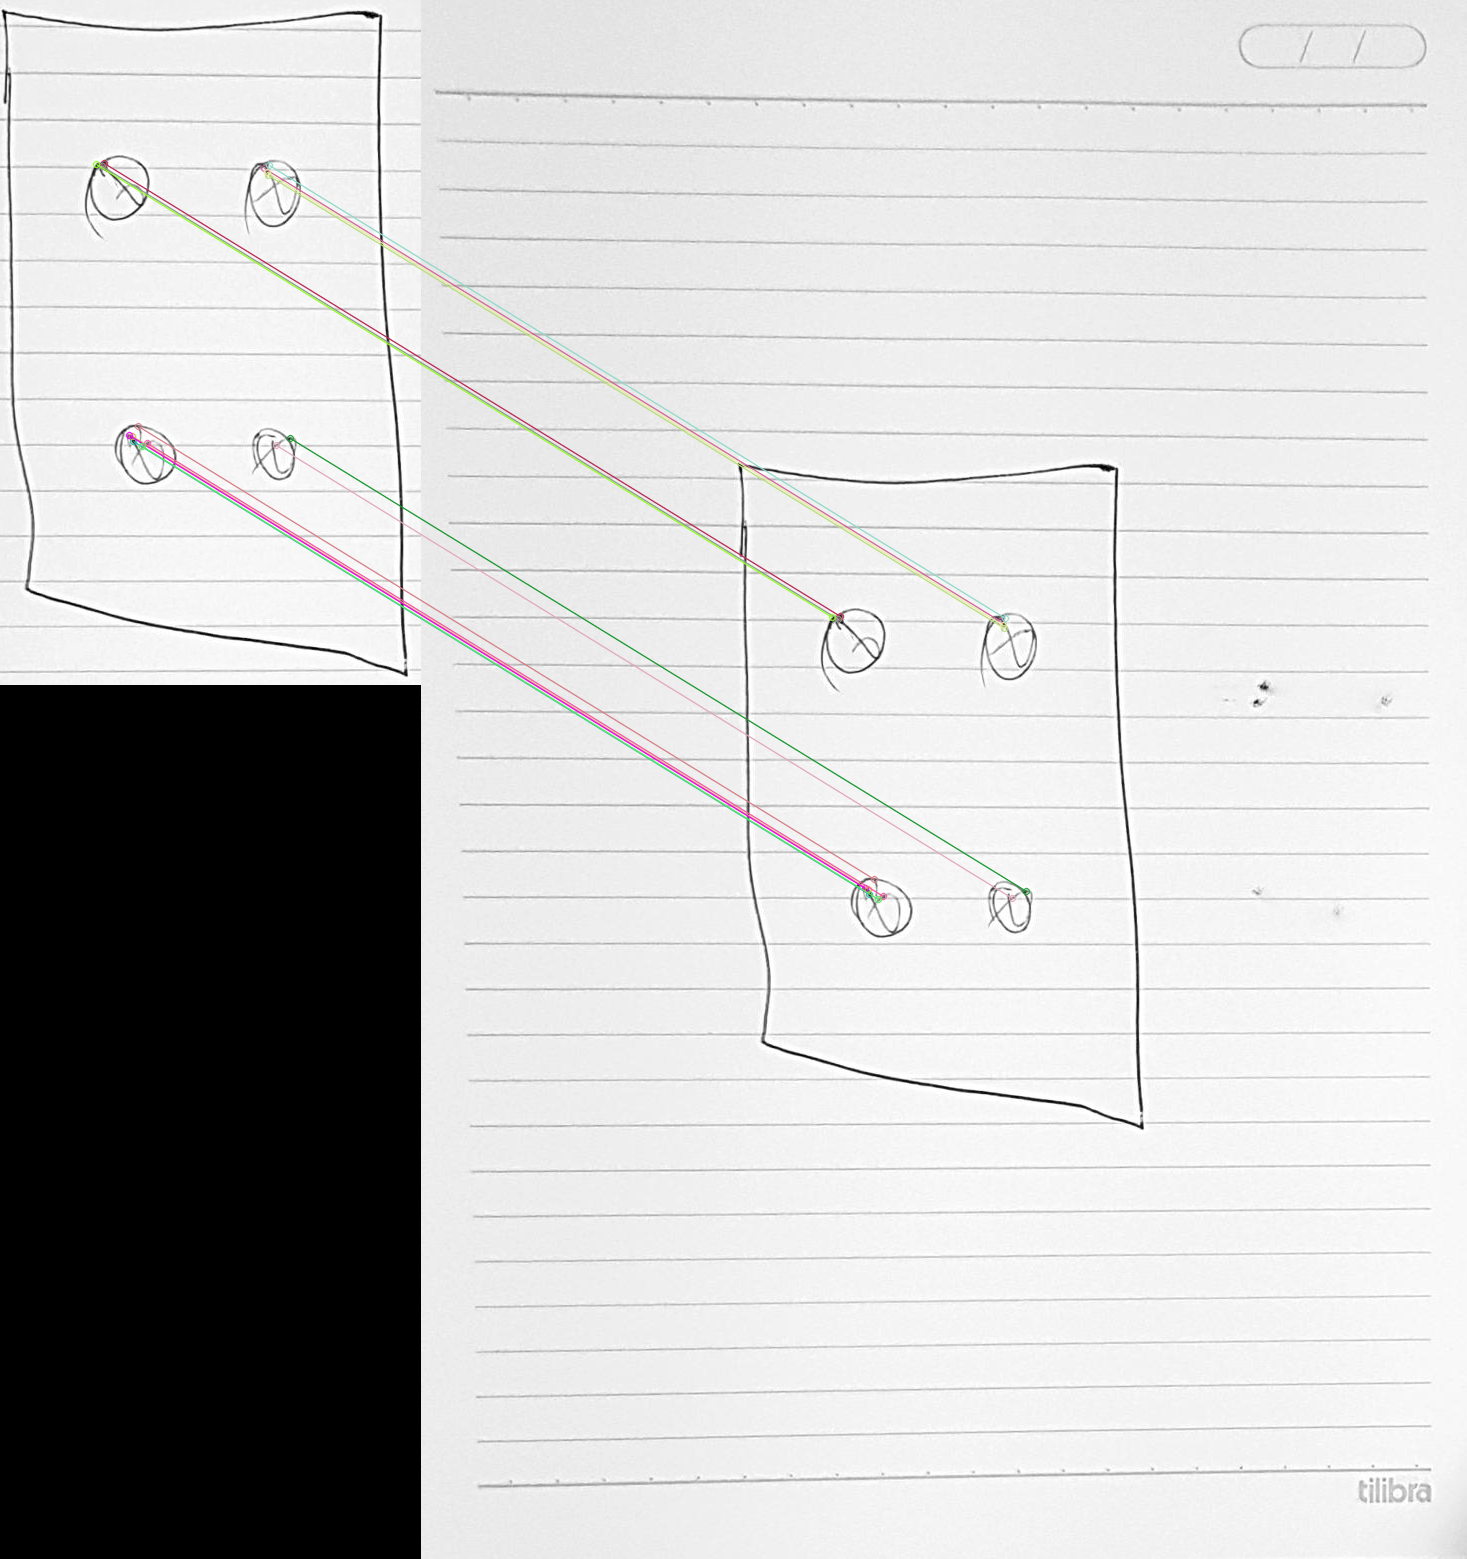

In [42]:
MIN_MATCHES = 15
cap = cv2.imread('reference.jpeg', 0)    
model = cv2.imread('reference_board.png', 0)

orb = cv2.ORB_create()              

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)  

kp_model, des_model = orb.detectAndCompute(model, None)  

kp_frame, des_frame = orb.detectAndCompute(cap, None)

matches = bf.match(des_model, des_frame)

matches = sorted(matches, key=lambda x: x.distance)

if len(matches) > MIN_MATCHES:
    cap = cv2.drawMatches(model, kp_model, cap, kp_frame,
                          matches[:MIN_MATCHES], 0, flags=2)
    cv2_imshow(cap)
else:
    print("Not enough matches have been found - %d/%d" % (len(matches),MIN_MATCHES))

## image surface normalization

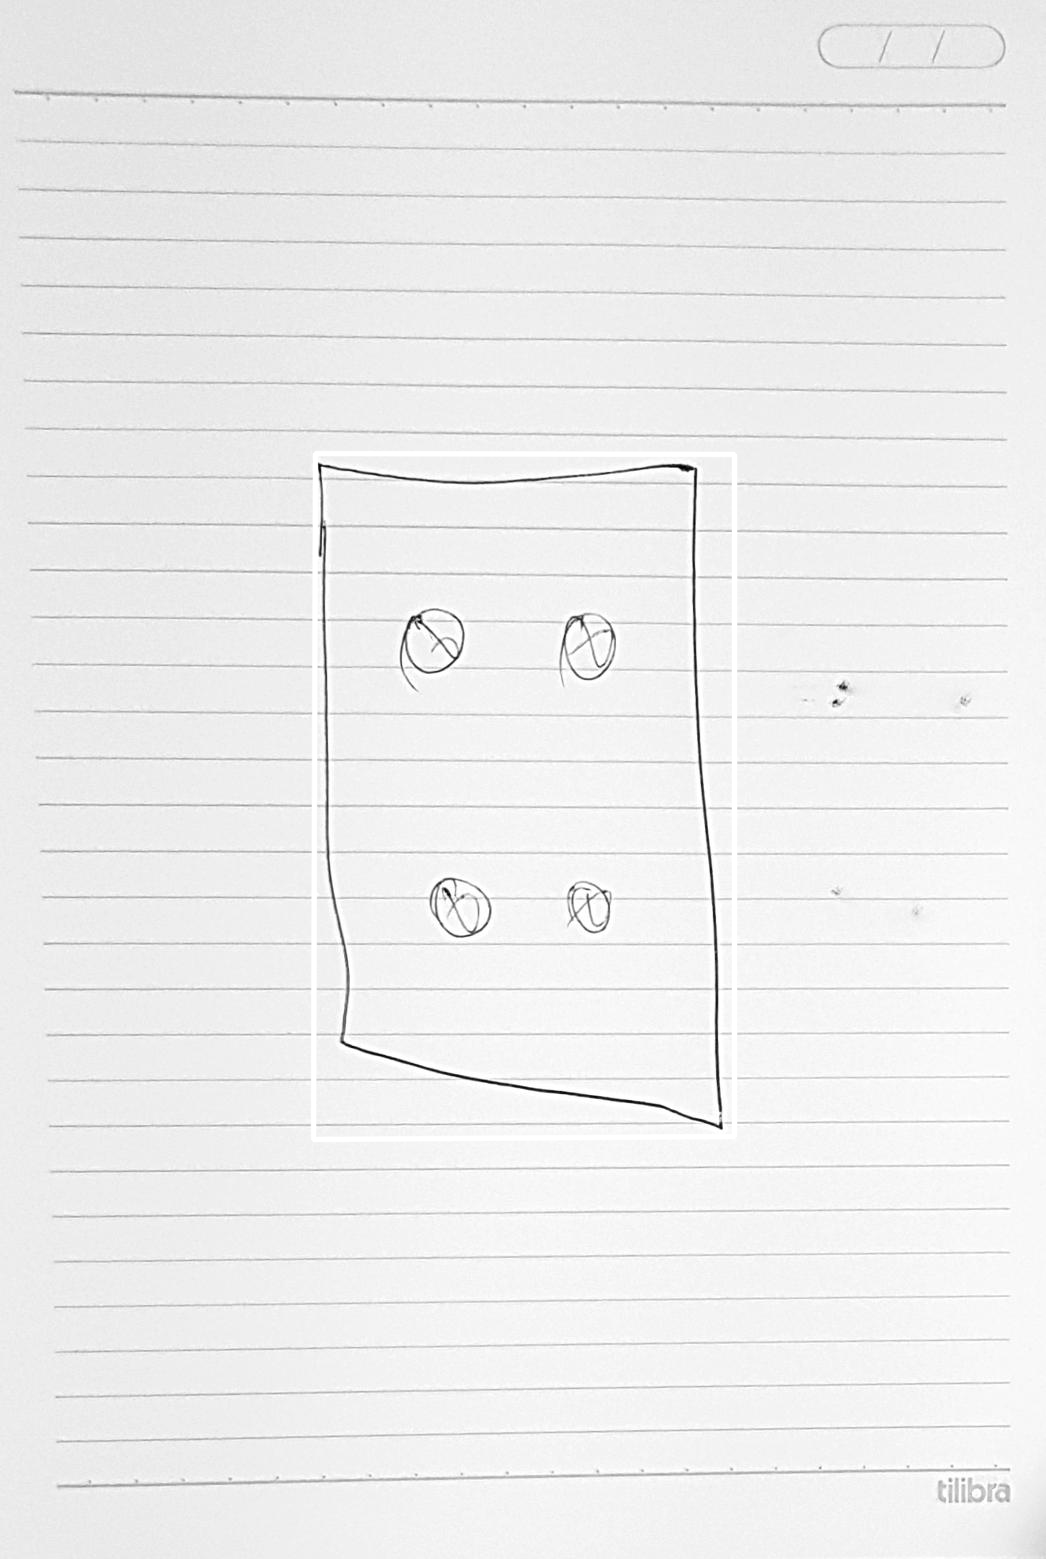

In [43]:
img = cv2.imread('reference.jpeg', 0)    

src_pts = np.float32([kp_model[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp_frame[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

h, w = model.shape
pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
dst = cv2.perspectiveTransform(pts, M)  

img2 = cv2.polylines(img, [np.int32(dst)], True, 255, 3, cv2.LINE_AA) 
cv2_imshow(img2)

In [44]:
fourcc = cv2.VideoWriter_fourcc(*'XVID')
cap = cv2.VideoCapture('video_hd.mp4')
out = cv2.VideoWriter('out_rectangle.avi', fourcc, 20.0, (int(cap.get(3)),int(cap.get(4))))

while cap.isOpened():
  ret, img = cap.read()
  if not ret:
      print("Unable to capture video, stream ending")
      break
  
  src_pts = np.float32([kp_model[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
  dst_pts = np.float32([kp_frame[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
  M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

  h, w = model.shape
  pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
  dst = cv2.perspectiveTransform(pts, M)  

  frame = cv2.polylines(img, [np.int32(dst)], True, 255, 3, cv2.LINE_AA)
  out.write(frame)

out.release()
cap.release()

Unable to capture video, stream ending
